In [1]:
import torch
import matplotlib.pyplot as plt

from rbi.visualization.surface_plots import plot_2d_surface
from rbi.utils.datasets import get_datasets
from rbi.utils.nets import IndependentGaussianNet
from rbi.defenses.regularized_loss import GaussianNoiseJacobiRegularizer, WorstCaseJacobiRegularizer
from rbi.loss.loss_fn import NLLLoss

torch.manual_seed(0)

In [2]:
train_loader, test_loader = get_datasets("regression", 1000, 2000, d=1)

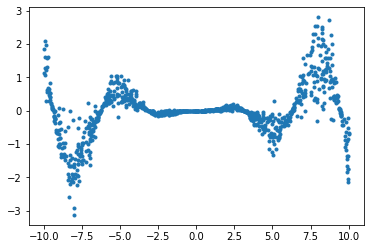

In [3]:
for X,y in train_loader:
    plt.plot(X, y, ".", color="C0")

In [6]:
net1 = IndependentGaussianNet(1, 1, prediction_fn="mean")
loss_fn = NLLLoss(net1)

In [7]:
optim = torch.optim.Adam(net1.parameters(), lr=5e-3)
for i in range(3000):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%1000)==0:
        print(loss.detach())

tensor(1.2747)
tensor(-0.6798)
tensor(-0.8274)


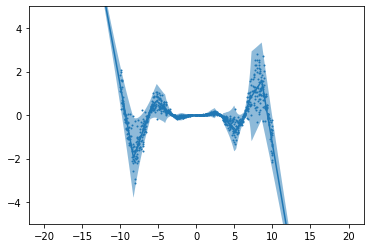

In [11]:
with torch.no_grad():
    x = torch.linspace(-20, 20, 1000)
    rv = net1(x.reshape(-1,1))
    plt.plot(x, rv.base_dist.loc)
    plt.fill_between(x.flatten(), torch.flatten(rv.base_dist.loc-3*rv.base_dist.scale), torch.flatten(rv.base_dist.loc + 3*rv.base_dist.scale), alpha=0.5)

    for X,y in train_loader:
        plt.scatter(X, y, s=1, color="C0")

    plt.ylim(-5,5)

In [20]:
from rbi.defenses.regularized_loss import GaussianNoiseTransformRegularizer
from rbi.utils.nets import MultivariateGaussianNet


In [21]:
net2 = MultivariateGaussianNet(1,1, prediction_fn="mean")
loss_fn = NLLLoss(net2)
#defense = GaussianNoiseJacobiRegularizer(net2, loss_fn, 0.3)
defense = GaussianNoiseTransformRegularizer(net2, loss_fn, 0.5)
defense.activate()

In [22]:
optim = torch.optim.Adam(net2.parameters(), lr=5e-3)
for i in range(3000):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%1000)==0:
        print(loss.detach())

tensor(1.1550)
tensor(-0.4532)
tensor(-0.5434)


KeyboardInterrupt: 

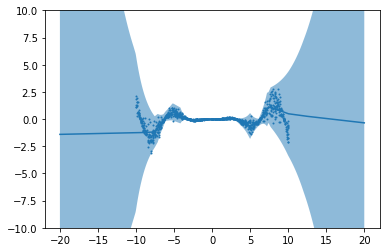

In [25]:
with torch.no_grad():
    x = torch.linspace(-20, 20, 1000)
    rv = net2(x.reshape(-1,1))
    plt.plot(x, rv.mean)
    plt.fill_between(x.flatten(), torch.flatten(rv.mean-3*rv.stddev), torch.flatten(rv.mean + 3*rv.stddev), alpha=0.5)

    for X,y in train_loader:
        plt.scatter(X, y, s=1, color="C0")

    plt.ylim(-10,10)

In [10]:
net3 = IndependentGaussianNet(1,1, prediction_fn="mean")
loss_fn = NLLLoss(net3)
defense = WorstCaseJacobiRegularizer(net3, loss_fn, 0.3)
defense.activate()

In [11]:
optim = torch.optim.Adam(net3.parameters(), lr=1e-3)
for i in range(3000):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%1000)==0:
        print(loss.detach())

tensor(0.9518)
tensor(-0.1245)
tensor(-0.2528)


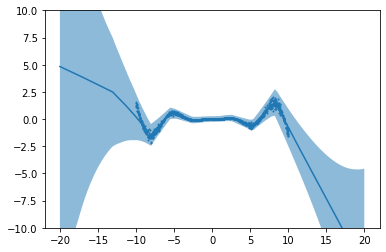

In [12]:
with torch.no_grad():
    x = torch.linspace(-20, 20, 1000)
    rv = net3(x.reshape(-1,1))
    plt.plot(x, rv.loc)
    plt.fill_between(x.flatten(), torch.flatten(rv.loc-3*rv.scale), torch.flatten(rv.loc + 3*rv.scale), alpha=0.5)

    for X,y in train_loader:
        plt.scatter(X, y, s=1, color="C0")

    plt.ylim(-10,10)

In [13]:
from rbi.attacks.advertorch_attack import GradientAttack, L2PGDAttack
from rbi.metrics.empirical_metrics import EmpiricalLossMetric

In [14]:
attack = L2PGDAttack(net1, loss_fn._loss, eps=0.5, nb_iter=500, clip_min=-100, clip_max=100)
attack._get_predicted_label = lambda x: net1.predict(x).detach()
attack._verify_and_process_inputs = lambda x,y : (x,attack._get_predicted_label(x))
metric = EmpiricalLossMetric(net1, attack, loss_fn)
clean_loss1 = metric.eval_clean(test_loader)
perturbed_loss1 = metric.eval_perturbed(test_loader)

attack = L2PGDAttack(net2, loss_fn._loss, eps=0.5, nb_iter=500, clip_min=-100, clip_max=100)
attack._get_predicted_label = lambda x: net1.predict(x).detach()
attack._verify_and_process_inputs = lambda x,y : (x,attack._get_predicted_label(x))
metric = EmpiricalLossMetric(net2, attack, loss_fn)
clean_loss2 = metric.eval_clean(test_loader)
perturbed_loss2 = metric.eval_perturbed(test_loader)

attack = L2PGDAttack(net3, loss_fn._loss, eps=0.5, nb_iter=500, clip_min=-100, clip_max=100)
attack._get_predicted_label = lambda x: net1.predict(x).detach()
attack._verify_and_process_inputs = lambda x,y : (x,attack._get_predicted_label(x))
metric = EmpiricalLossMetric(net3, attack, loss_fn)
clean_loss3 = metric.eval_clean(test_loader)
perturbed_loss3 = metric.eval_perturbed(test_loader)

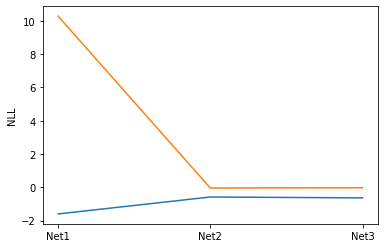

In [15]:
with torch.no_grad():
    plt.plot(["Net1", "Net2", "Net3"], [clean_loss1, clean_loss2, clean_loss3])
    plt.plot(["Net1", "Net2", "Net3"], [perturbed_loss1, perturbed_loss2, perturbed_loss3])
    plt.ylabel("NLL")